In [1]:
import numpy as np
import trident
import yt
import os
import sys
import matplotlib.pyplot as plt
from quasar_scan import *
from parse_vela_metadata import Rdict, Ldict

In [2]:
class MultiQuasarSphereAnalyzer():
    #USER MUST EXPLICITLY CALL GET_QUASAR TO INPUT INTO ALL OTHER MULTIQUASARSPHEREANALYZER METHODS AS NECESSARY
    
    
    
    def __init__(self, textfiles):
        self.quasarLineup = []
        for textfile in textfiles:
            simparams,scanparams,ions,data = read_values(textfile)
            q = QuasarSphere(simparams = simparams,scanparams = scanparams,ions = ions,data = data, readonly = True)
            self.quasarLineup.append(q)
        print self.quasarLineup
        
    def get_quasar(self, simname, redshift, ions = None):
        result = None
        for quasar in self.quasarLineup:
            tempSimName = quasar.simparams[0]
            tempRedshift = round(quasar.simparams[1], 2)
            if ions:
                tempIons = quasar.ions
                if tempSimName == simname and tempRedshift == redshift and tempIons == ions:
                    return quasar
            else:
                if tempSimName == simname and tempRedshift == redshift:
                    return quasar
        print ("Quasar with inputted characteristics not found.")
    

    #summary: plots an a pyplot errorbar graph with the x-axis being either theta, phi, or the radius; 
    #         the y-axis points are the mean column densities with a spread of +/- the error
    #         quasarArray is the array of quasars to be plotted
    def plot_coldens_error_bars(self, quasarArray, ion, xVar = "r", more_info = False, save_fig = False):

        plt.figure()
        #axs.errorbar(x[1:], y[1:], yerr=yerr[1:], fmt='_')

        xlabels = {"r":"r (kpc)","r>0":"r (kpc)","rdivR":"r/Rvir","theta":"viewing angle (rad)","phi" \
                   :"azimuthal viewing angle (rad)"}
        
        plt.xlabel(xlabels[xVar])
        plt.ylabel("log col dens")
        plt.title('%s Column Density Averages vs %s' % (ion, xVar) )

        for index in range(len(quasarArray)):
            q = quasarArray[index]
            #list of all possibles xVals, with no repeats
            allX = self.find_xVars_Info(q, xVar)
            x = np.unique(allX)


            #list of column density AVERAGES corresponding to the respective xVal
            y = np.zeros(len(x))
            yerr = np.zeros(len(x))


            ionIndex = -1
            for index in range(len(q.ions)):
                if q.ions[index] == ion:
                    ionIndex = index
            if ionIndex == -1:
                print ("Ion not found. Please enter a different ion.")
                return
            print ("Ion index found at %d \n" %ionIndex)


            allColdens = q.info[:,11 + ionIndex] 


            #loops to find column density (y) mean and +/- error
            
            for index in range(len(x)):

                yTemp = allColdens[allX == x[index]]

                logYTemp = np.log10(yTemp)
                if more_info:
                    print ("At x value %f, log y is %s" % (x[index], logYTemp))

                #finds mean at given xVar  
                avg = np.mean(logYTemp)
                y[index] = avg

                print ("Column density mean at %5f %s is %5f" % (x[index], xVar, avg))

                stdev = np.std(logYTemp)
                error = stdev / np.sqrt(len(logYTemp)-1)
                yerr[index] = error
                if more_info:
                    print("+/- error value is %5f \n" %error)
            plt.errorbar(x, y, yerr=yerr, fmt='_', label = q.simparams[0])
            plt.legend()


        if save_fig == True:
            ionNameNoSpaces = ion.replace(" ","")
            name = "%s_z%0.2f_ErrorBar_%s_%s" % (q.simparams[0], q.simparams[1], ionNameNoSpaces, xVar)
            plt.savefig(name + ".png")
    
    #precondition: xVar must be "theta","phi","r","r>0","rdivR"
    #summary: calculates the right index corresponding to xvariable, then finds (in 'info') and returns that array 
    def find_xVars_Info(self, q, xvariable):
        if xvariable == "r" or xvariable == "r>0":
            conversion = q.simparams[10]
        elif xvariable == "rdivR":
            if q.simparams[5] > 0:
                conversion = q.simparams[10]/q.simparams[5]
            else:
                print("No virial radius found")
                return
        else:
            if q.simparams[5] < 0:
                print("No metadata, angle plots will be arbitrary axis.")
        conversion = 1

        vardict = {"theta":1,"phi":2,"r":3,"r>0":3,"rdivR":3}
        if not (xvariable in vardict):
            print ("Inputted xvariable not found. Please enter a valid xvariable.")
            return

        return q.info[:, vardict[xvariable]]*conversion
    
    
    def plot_hist(self, q, simname = None,xvariable = "r",zeros = "ignore",\
                  weights = True,save_fig = None,ns = (42,15),do_ions = "all"):
        if not simname:
            simname = q.simparams[0]
        if xvariable == "r" or xvariable == "r>0":
            conversion = q.simparams[10]
        elif xvariable == "rdivR":
            if q.simparams[5] > 0:
                conversion = q.simparams[10]/q.simparams[5]
            else:
                print("No virial radius found")
                return
        else:
            if q.simparams[5] < 0:
                print("No metadata, angle plots will be arbitrary axis.")
            conversion = 1
        if do_ions == "all":
            ions = q.ions
        else:
            ions = do_ions
        vardict = {"theta":1,"phi":2,"r":3,"r>0":3,"rdivR":3}
        #ion,xvars,cdens,simname
        for i in range(len(q.ions)):
            end = q.scanparams[6]
            if q.ions[i] in ions:
                plot2dhist(q.ions[i],q.info[:end,vardict[xvariable]]*conversion,\
                       q.info[:end,11+i],simname,xvariable = xvariable, ns = ns,zeros = zeros,\
                       weights = weights,save_fig = save_fig,z = q.simparams[1])
                
def plot2dhist(ion,xvars,cdens,simname,xvariable = "r",ns = (42,15),zeros = "ignore",weights = True, save_fig = None, z = None):
    if zeros == "ignore":
        xvars = xvars[cdens>0]
        cdens = cdens[cdens>0]
        logdens = np.log10(cdens)
    else:
        logdens = np.log10(np.maximum(cdens,1e-15))
    if xvariable == "r>0":
        logdens = logdens[xvars>0.0]
        xvars = xvars[xvars>0.0]
    nx = ns[0]
    ny = ns[1]
    plotvars = {"r":"r","r>0":"r","rdivR":"r","theta":"theta","phi":"phi"}
    plotvar = plotvars[xvariable]
    if weights:
        weight = xvars*0.0
        for i in range(len(xvars)):
            weight[i] = 1.0/len(xvars[xvars==xvars[i]])
        H, xedges, yedges = np.histogram2d(xvars, logdens, bins=[nx,ny],weights = weight)
        cbarlabel = "Fraction of lines for fixed %s"%(plotvar)
    else:
        H, xedges, yedges = np.histogram2d(xvars, logdens, bins=[nx,ny])
        cbarlabel = "Total number of lines"
    H = H.T
    X, Y = np.meshgrid(xedges, yedges)
    plt.pcolormesh(X,Y, H, cmap=hotcustom)
    plt.title("distribution of "+ion+" in "+simname+" at z="+str(z)[:4])
    # set the limits of the plot to the limits of the data
    #plt.axis([x.min(), x.max(), y.min(), y.max()])
    plt.colorbar(label = cbarlabel)
    x1,x2,y1,y2 = plt.axis()
    dx = x2-x1
    dy = y2-y1
    plt.axis((x1-dx*0.1,x2+dx*0.1,y1-dy*0.1,y2+dy*0.1))
    xlabels = {"r":"r (kpc)","r>0":"r (kpc)","rdivR":"r/Rvir","theta":"viewing angle (rad)","phi":"azimuthal viewing angle (rad)"}
    plt.xlabel(xlabels[xvariable])
    plt.ylabel("log col dens")
    if save_fig:
        if save_fig == "default" :
            save_fig = simname + "_" + plotvar + "_z" +str(z)[:4]
        name = save_fig+"_"+ion.replace(" ","")
        if weights:
            name +="_w"
        if zeros == "ignore":
            name +="_nozeros"
        plt.savefig(name+".png")
    plt.show()


    
        
    #def graph_by_VELA_galaxy():
        
    #def graph_by_redshift():
        
        


In [ ]:
textfile = '/Users/bryanwang/quasarscan/output/VELA_v2_03coldensinfo/406_of_400-_OVI_NeVIII_HI_CIII_OIV_NIII_MgII_OV_OIII_NIV_MgX_NV_SIV_OII_SIII_SII_SV_SVI_NII_z0.99.txt'
simparams, scanparams, ions, data = read_values(textfile)
q = QuasarSphere(simparams = simparams, scanparams = scanparams, ions = ions, data = data, readonly = True)
q.__dict__.keys()

[<quasar_scan.QuasarSphere object at 0x115776050>, <quasar_scan.QuasarSphere object at 0x115936cd0>]
Ion index found at 0 

At x value 0.000000, log y is [13.82212684 13.91925359 13.30551969 12.55585047 14.26157104 14.1119011
 13.72299936 14.24723251 13.12415781 12.87341692 12.14887289 12.15793023
 14.45310816 13.56454164 13.45056471 13.35678182 15.6889468  13.59371879
 12.67201094 13.09276898 11.62114318 12.42381494 13.30993065 10.72012444
 13.55665301 13.20319103 13.4622865  13.88128049 12.27500903 13.3954398
 13.33305546 13.21478397 13.79170106 13.70788131 12.58324905 13.8878031
 13.39570197 13.57698254]
Column density mean at 0.000000 phi is 13.301666
+/- error value is 0.139780 

At x value 0.523599, log y is [13.50577185 12.89911419 13.74170867 13.14203307 13.52346344 11.66217729
 13.48056207 11.664962   13.57695342 12.46680234 12.59867114 12.33186716
 13.25705525 12.97748723 13.06522591 12.24802549 14.06109125 14.42714786
 14.58116214 14.42276839 13.40228178 11.6094207  14.34384

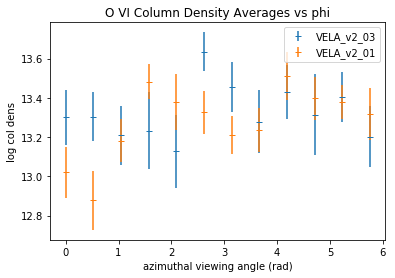

In [6]:
textfile = ['/Users/bryanwang/quasarscan/output/VELA_v2_03coldensinfo/406_of_400-_OVI_NeVIII_HI_CIII_OIV_NIII_MgII_OV_OIII_NIV_MgX_NV_SIV_OII_SIII_SII_SV_SVI_NII_z0.99.txt', '/Users/bryanwang/quasarscan/output/VELA_v2_01coldensinfo/406_of_400-_OVI_NeVIII_HI_CIII_OIV_NIII_MgII_OV_OIII_NIV_MgX_NV_SIV_OII_SIII_SII_SV_SVI_NII_z0.99.txt']
mq = MultiQuasarSphereAnalyzer(textfile)
q1 = mq.get_quasar("VELA_v2_03", 1.00)
q2 = mq.get_quasar("VELA_v2_01", 1.00)


#mq.plot_hist(0,do_ions = ["O VI","Ne VIII"])
mq.plot_coldens_error_bars([q1, q2],"O VI", xVar = "phi", more_info = True)
